In [ ]:
import sys, subprocess, importlib, os
REPO_URL = "https://github.com/khayhamz31/d2v_copy"
REPO_DIR = "Dataset2Vec"

if not os.path.exists(REPO_DIR):
    subprocess.run(
        ["git", "clone", "--depth", "1", REPO_URL, REPO_DIR],
        check=True
    )
    print(f"Cloned repository into ./{REPO_DIR}")
else:
    print("dataset2vec already present in project root.")

### Environment Imports  
Core libraries, OpenML access, widgets for UI, and project modules for:
- downloading datasets  
- extracting traditional & D2V meta-features  
- aggregating runs  
- training meta-classifier and meta-regressor models  

In [1]:
import warnings
import openml
import ipywidgets as widgets
import time
import os
import pandas as pd
from IPython.display import clear_output, display
warnings.filterwarnings("ignore", category=RuntimeWarning)

# SET OPENML KEY HERE 
openml.config.apikey = "3ba6ade3f263806d251fb5641e1b2793"
from datasets import (
    download_benchmark_suite,
    download_and_process_dataset,
    download_datasets_from_df
)

from qualities import extract_metafeatures_from_local_datasets

from d2v_qualities import extract_metafeatures_from_datasets

from runs import run_pipeline

from metaclassifier import run_meta_classifier

from metaregressor import run_meta_regressor_multioutput

from regressor_comparison import plot_regressor_as_classifier_results

# set random seed for reproducibility
random_seed = 411

### Benchmark Suite Selection  
Fetch OpenML benchmark suites with retry logic, display a dropdown selector, and download datasets from the chosen suite 

In [ ]:
max_retries = 3
delay = 5

for attempt in range(max_retries):
    try:
        suites_df = openml.study.list_suites(output_format="dataframe", status="all")
        break
    except openml.exceptions.OpenMLServerException:
        if attempt < max_retries - 1:
            time.sleep(delay)
        else:
            raise RuntimeError("Failed to fetch benchmark suites after multiple retries.")

suites_df["alias"] = suites_df["alias"].fillna("unnamed")
options = [(f"{alias} ({sid})", sid) for sid, alias in zip(suites_df["id"], suites_df["alias"])]

dropdown = widgets.Dropdown(
    options=options,
    description='Suite:',
    layout=widgets.Layout(width='60%')
)
output = widgets.Output()
selected_suite_info = {"id": None, "alias": None}

def on_dropdown_change(change):
    if change["type"] == "change" and change["name"] == "value":
        with output:
            clear_output()
            sid = change["new"]
            alias = next(label.split(" (")[0] for label, val in options if val == sid)
            selected_suite_info.update({"id": sid, "alias": alias})
            print(f"Downloading: {alias} ({sid})...")
            res = download_benchmark_suite(sid)
            print(f"{res['successful']}/{res['total']} downloaded, {res['failed']} failed.")

dropdown.observe(on_dropdown_change)
display(dropdown, output)

In [2]:
selected_suite_info = {"id": 99, "alias": 'OpenML-CC18'}

### Meta-feature extraction 
1. Extracts meta-features from openml for the datasets downloaded
2. Extracts Dataset2Vec meta-features from the datasets downloaded

In [3]:
df_local = extract_metafeatures_from_local_datasets("test_datasets")
stats = extract_metafeatures_from_datasets()

🔍 Found 72 datasets: [307, 300, 40978, 1067, 50, 40982, 1468, 32, 1461, 40983, 40984, 40979, 1050, 1068, 1494, 151, 40923, 40668, 40499, 23381, 1590, 1501, 1487, 18, 1480, 1489, 11, 29, 16, 4538, 6, 28, 188, 1475, 1486, 40701, 44, 40996, 38, 31, 1462, 40975, 1063, 54, 1497, 1464, 37, 40927, 554, 1053, 6332, 1510, 458, 469, 40670, 23517, 46, 40994, 1049, 41027, 23, 15, 4134, 3, 12, 4534, 40966, 1478, 14, 182, 22, 1485]
📁 Raw metafeatures saved to: qualities/traditional/metafeatures_raw.csv (72 rows, 108 columns)
ℹ️ Missing data before imputation: 21.02%
✅ Processed metafeatures saved to: qualities/traditional/metafeatures.csv (72 rows, 108 columns)
[INFO] Found 72 datasets in 'test_datasets'


Extracting meta-features: 100%|██████████| 72/72 [06:13<00:00,  5.18s/it]

[SUMMARY] Extracted: 72, Skipped: 0
[DONE] Combined meta-features saved to 'qualities/d2v/metafeatures.csv' ((72, 32))


### Meta-target extraction
1. Downloads and samples run data from OpenML for the datasets downloaded

In [3]:
run_pipeline(
    mapping_path="test_datasets/id_task_mapping.json",
    flow_map_path="flows/filtered_flow_algorithm_mapping_v2.json",
    sample_size=50,
    batch_size=50,
    base_dir="runs"
)

[2/4] Filtering & sampling:   3%|▎         | 2/72 [00:00<00:14,  4.88it/s]/Users/anukhayri/Desktop/algoselectionpipeline-1/runs.py:50: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  runs_df = pd.read_csv(input_path)
[4/4] Building metatargets: 100%|██████████| 72/72 [00:00<00:00, 221.35it/s]


### Meta-classifier
1. Trains meta-classifier 
2. Evaluates meta-classifier performance (LOOCV with n_repeats)
3. Visualises with boxplot and simple statistics (mean accuracy ± std )


📊 Summary of Meta-Learning Performance:
Feature Set    Mean ± Std
        D2v 0.315 ± 0.021
     Hybrid 0.479 ± 0.028
Traditional 0.519 ± 0.022


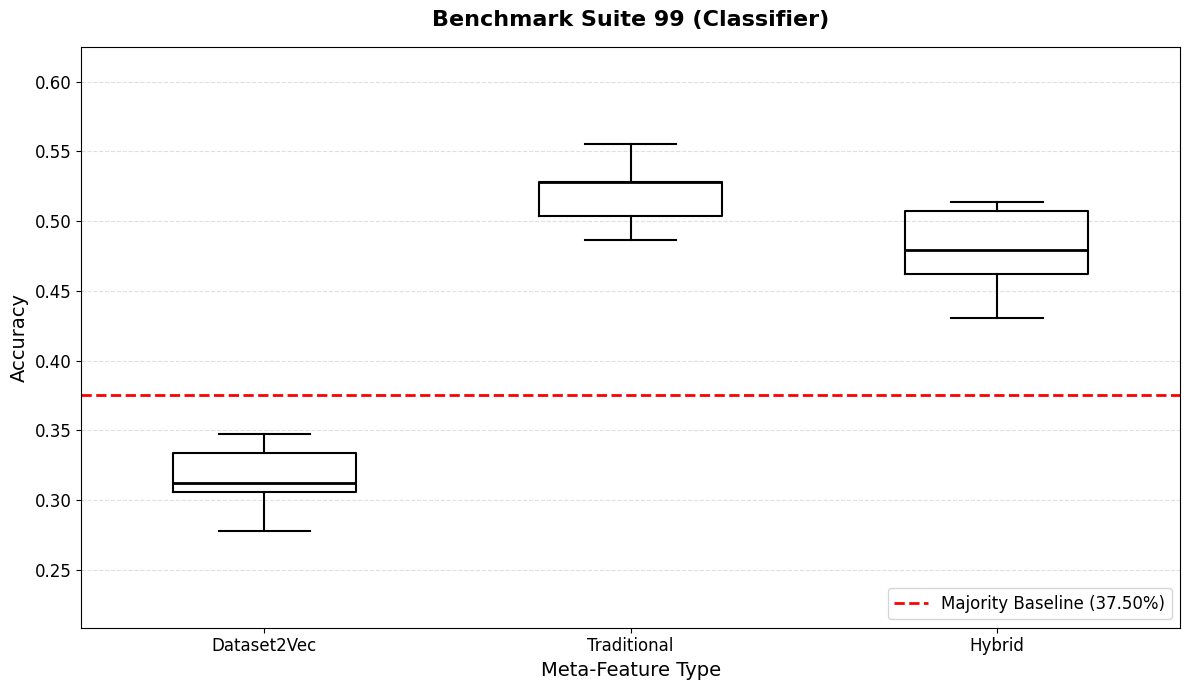

In [4]:
results, majority_acc, summary, (fig, ax) = run_meta_classifier(
    # choosing performance metrics (accuracy or f1)
    metric_name="accuracy",
    # change for algorithm subsets ['decision_tree','random_forest','xgboost','linear_models','support_vector_machine'] or None for all 
    algorithms=None,
    # change number of repeats (numer of meta-models)
    n_repeats=10,
    # Change random seed for reproducibility
    seed = random_seed,
    # Change title for plot
    plot_title="Benchmark Suite 99 (Classifier)"
)

### Meta-Regressor 
1. Trains the meta-regressor  
2. Evaluates meta-regressor performance (LOO-CV with n_repeats)
3. Saves simple statistics and predictions to the results folder


In [5]:
results, baseline_mae, summary_df = run_meta_regressor_multioutput(
    # choosing performance metrics (accuracy or f1)
    metric_name="accuracy",
    # change for algorithm subsets ['decision_tree','random_forest','xgboost','linear_models','support_vector_machine'] or None for all
    algorithms=None,
    # change number of repeats (numer of meta-models)
    n_repeats=10,
    # change random seed for reproducibility
    seed = random_seed,
    # change folder to save regressor results
    output_dir="meta_regressor_results",
)

[INFO] Running self-healing accuracy filler...
[INFO] Loaded accuracy matrix: (72, 5)
[INFO]   Columns: ['random_forest', 'support_vector_machine', 'linear_models', 'xgboost', 'decision_tree']
[INFO]   Index: [1494, 1050, 1068, 40975, 40927]...
[INFO] Initial NaN count: 6
[INFO]   NaN per column: {'random_forest': 1, 'support_vector_machine': 1, 'linear_models': 2, 'xgboost': 2, 'decision_tree': 0}
[INFO] Found 3 datasets with missing accuracies:
[INFO]   Dataset 40927: ['support_vector_machine', 'linear_models', 'xgboost']
[INFO]   Dataset 40978: ['random_forest']
[INFO]   Dataset 40923: ['linear_models', 'xgboost']


Filling missing accuracies:   0%|          | 0/3 [00:00<?, ?it/s]

[INFO] 
[INFO] Dataset 40927: Computing 3 algorithms
[INFO] ======================================================================
[INFO] Starting accuracy computation for dataset 40927
[INFO]   Missing algorithms: ['support_vector_machine', 'linear_models', 'xgboost']
[INFO] Loading dataset 40927...
[INFO]   Data file: test_datasets/40927/40927_py.dat
[INFO]   Labels file: test_datasets/40927/labels_py.dat
[INFO]   ✓ Data loaded: shape (60000, 3072), dtype float64
[INFO]   ✓ Labels loaded (with delimiter): shape (60000,), dtype float64
[INFO]   → Converted to int: shape (60000,)
[INFO] Dataset loaded: X.shape=(60000, 3072), y.shape=(60000,)
[INFO]   X dtype: float64, y dtype: int64
[INFO]   Unique labels: [0 1 2 3 4 5 6 7 8 9]
[INFO]   ⚠ Dataset too large (60000 samples), subsampling to 20000...
[INFO]   → Subsampled to: X.shape=(20000, 3072)
[INFO] Using 3-fold Stratified K-Fold CV
[INFO] 
Training support_vector_machine...
[INFO]   Model: LinearSVC
[INFO]   Fold 1: train=13333, test

Filling missing accuracies:  33%|███▎      | 1/3 [47:12<1:34:25, 2832.64s/it]

[INFO]     → Fold accuracy: 0.3446
[INFO]   ✓ xgboost: 0.3495 ± 0.0044
[INFO] Completed accuracy computation for dataset 40927

[INFO] ✓ Updated support_vector_machine: 0.3336
[INFO] ✓ Updated linear_models: 0.3406
[INFO] ✓ Updated xgboost: 0.3495
[INFO] 
[INFO] Dataset 40978: Computing 1 algorithms
[INFO] ======================================================================
[INFO] Starting accuracy computation for dataset 40978
[INFO]   Missing algorithms: ['random_forest']
[INFO] Loading dataset 40978...
[INFO]   Data file: test_datasets/40978/40978_py.dat
[INFO]   Labels file: test_datasets/40978/labels_py.dat
[INFO]   ✓ Data loaded: shape (3279, 1558), dtype float64


Filling missing accuracies:  67%|██████▋   | 2/3 [47:12<19:26, 1166.58s/it]  

[INFO]   ✓ Labels loaded (with delimiter): shape (3279,), dtype float64
[INFO]   → Converted to int: shape (3279,)
[INFO] Dataset loaded: X.shape=(3279, 1558), y.shape=(3279,)
[INFO]   X dtype: float64, y dtype: int64
[INFO]   Unique labels: [0 1]
[INFO] Using 3-fold Stratified K-Fold CV
[INFO] 
Training random_forest...
[INFO]   Model: RandomForestClassifier
[INFO]   Fold 1: train=2186, test=1093
[INFO]     → Fold accuracy: 0.9424
[INFO]   Fold 2: train=2186, test=1093
[INFO]     → Fold accuracy: 0.9451
[INFO]   Fold 3: train=2186, test=1093
[INFO]     → Fold accuracy: 0.9506
[INFO]   ✓ random_forest: 0.9460 ± 0.0034
[INFO] Completed accuracy computation for dataset 40978

[INFO] ✓ Updated random_forest: 0.9460
[INFO] 
[INFO] Dataset 40923: Computing 2 algorithms
[INFO] ======================================================================
[INFO] Starting accuracy computation for dataset 40923
[INFO]   Missing algorithms: ['linear_models', 'xgboost']
[INFO] Loading dataset 40923...
[I

Filling missing accuracies: 100%|██████████| 3/3 [1:11:49<00:00, 1436.47s/it]


[INFO]     → Fold accuracy: 0.5062
[INFO]   ✓ xgboost: 0.4973 ± 0.0065
[INFO] Completed accuracy computation for dataset 40923

[INFO] ✓ Updated linear_models: 0.6357
[INFO] ✓ Updated xgboost: 0.4973
[INFO] 
[INFO] Filled 6 missing values (0 failures)
[INFO] ======================================================================

[INFO] Updated accuracy matrix saved to meta_targets/accuracy.csv
[INFO]   Final shape: (72, 5)
[INFO]   Remaining NaN count: 0
[INFO] Loaded performance matrix: (72, 5)
[INFO] Algorithms: ['random_forest', 'support_vector_machine', 'linear_models', 'xgboost', 'decision_tree']
[INFO] Valid datasets for regression: 72
[INFO] Performance statistics:
       random_forest  support_vector_machine  linear_models    xgboost  \
count      72.000000               72.000000      72.000000  72.000000   
mean        0.864456                0.860059       0.824011   0.810628   
std         0.145523                0.160687       0.164076   0.183881   
min         0.213927   

[INFO]   MAE: 0.1322 ± 0.0014
[INFO]   MSE: 0.0331 ± 0.0006
[INFO]   R²:  -0.2838 ± 0.0222
[INFO] Per-algorithm MAE summary (d2v):
[INFO]   random_forest: 0.1205 ± 0.0016
[INFO]   support_vector_machine: 0.1332 ± 0.0019
[INFO]   linear_models: 0.1374 ± 0.0018
[INFO]   xgboost: 0.1460 ± 0.0012
[INFO]   decision_tree: 0.1240 ± 0.0016
[INFO] Evaluating hybrid meta-regression model...


[INFO]   MAE: 0.0716 ± 0.0008
[INFO]   MSE: 0.0132 ± 0.0002
[INFO]   R²:  0.4964 ± 0.0065
[INFO] Per-algorithm MAE summary (hybrid):
[INFO]   random_forest: 0.0634 ± 0.0007
[INFO]   support_vector_machine: 0.0620 ± 0.0017
[INFO]   linear_models: 0.0743 ± 0.0013
[INFO]   xgboost: 0.0897 ± 0.0024
[INFO]   decision_tree: 0.0687 ± 0.0015
[INFO] Evaluating traditional meta-regression model...


[INFO]   MAE: 0.0709 ± 0.0007
[INFO]   MSE: 0.0129 ± 0.0002
[INFO]   R²:  0.5088 ± 0.0075
[INFO] Per-algorithm MAE summary (traditional):
[INFO]   random_forest: 0.0608 ± 0.0009
[INFO]   support_vector_machine: 0.0615 ± 0.0008
[INFO]   linear_models: 0.0751 ± 0.0010
[INFO]   xgboost: 0.0906 ± 0.0017
[INFO]   decision_tree: 0.0667 ± 0.0009
[INFO] Majority Classifier Baseline:
[INFO]   Best overall algorithm: random_forest
[INFO]   Average performance: 0.8645
[INFO]   Majority classifier accuracy: 0.3472
[INFO] D2V Feature Set - Top-1 Accuracy:
[INFO]   Rep 1: Top-1 Accuracy = 0.3889 (28/72)
[INFO]   Rep 2: Top-1 Accuracy = 0.3750 (27/72)
[INFO]   Rep 3: Top-1 Accuracy = 0.3889 (28/72)
[INFO]   Rep 4: Top-1 Accuracy = 0.3889 (28/72)
[INFO]   Rep 5: Top-1 Accuracy = 0.3750 (27/72)
[INFO]   Rep 6: Top-1 Accuracy = 0.4028 (29/72)
[INFO]   Rep 7: Top-1 Accuracy = 0.3750 (27/72)
[INFO]   Rep 8: Top-1 Accuracy = 0.3889 (28/72)
[INFO]   Rep 9: Top-1 Accuracy = 0.3611 (26/72)
[INFO]   Rep 10: To

### Meta-regressor as classifier  
Uses meta-regressor outputs to visualises them in the same format as the meta-classifier for direct comparison.

Majority Baseline Accuracy: 0.3472

Generating boxplot...

📊 Summary of Meta-Regressor Top-1 Accuracy (as Classifier):
D2v: 0.3792 ± 0.0153
Hybrid: 0.4931 ± 0.0280
Traditional: 0.4778 ± 0.0198

Plot saved to: regresscomparison/regressor_as_classifier_boxplot.png


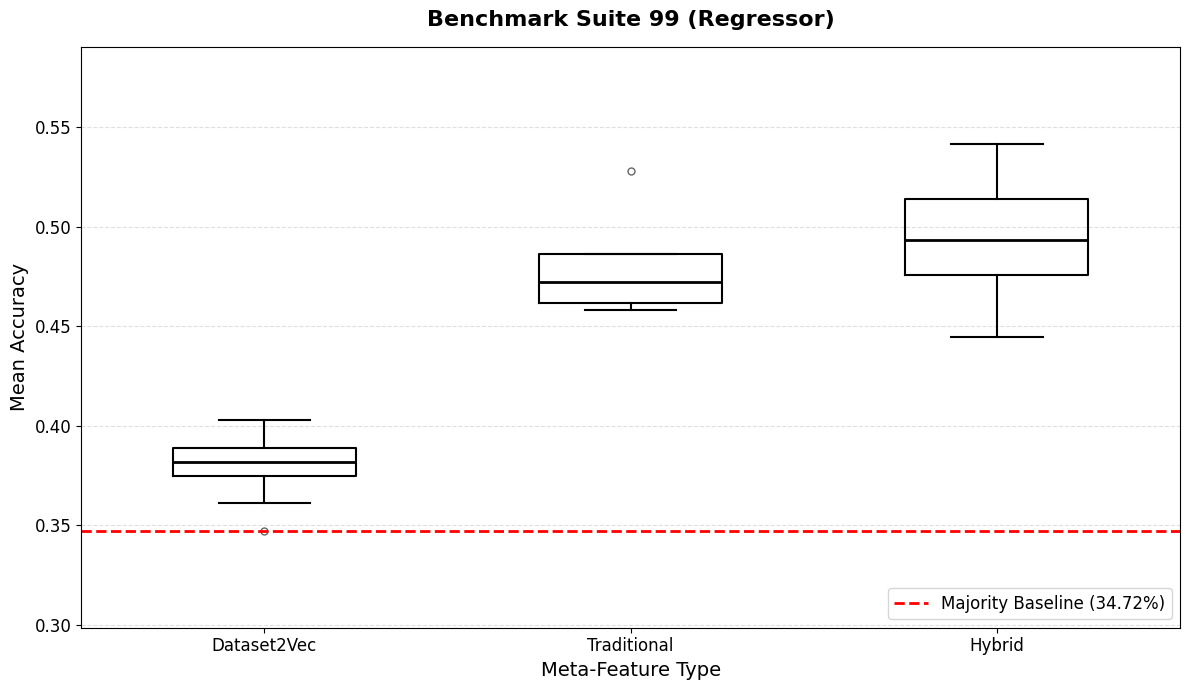

In [6]:
accuracies, majority_accuracy, summary_df, (fig, ax) = plot_regressor_as_classifier_results(
    # change to where meta_regressor results are stored
    analysis_csv="meta_regressor_results/analysis/top1_accuracy_analysis.csv",
    # change folder to save regressor as classifier
    output_dir="regresscomparison",
    # Change title for plot
    plot_title="Benchmark Suite 99 (Regressor)",
    ylabel="Mean Accuracy"
)

### Storing benchmark suite and random seed data 

In [7]:
from run_consolidation import consolidate_run_outputs

run_dir = consolidate_run_outputs(
    selected_suite_info=selected_suite_info,
    random_seed=random_seed,
)

run_dir


Moved: ['log', 'meta_classifier_results', 'meta_regressor_results', 'regresscomparison', 'meta_targets', 'qualities', 'runs', 'test_datasets']
Missing: []
Skipped: []


PosixPath('/Users/anukhayri/Desktop/algoselectionpipeline-1/suite_99_seed_411')